<a href="https://colab.research.google.com/github/rishika-v/CZ_takehome/blob/main/cz_ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#https://github.com/MouseLand/cellpose
#Stringer, C., Wang, T., Michaelos, M., & Pachitariu, M. (2021). Cellpose: a generalist algorithm for cellular segmentation. Nature methods, 18(1), 100-106.
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-n4_fqj87
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-n4_fqj87
  Resolved https://www.github.com/mouseland/cellpose.git to commit 61c1a9484db165bea6b5fe7af15337e6f2ae2fbc
  Preparing metadata (setup.py) ... done


In [13]:
from cellpose import models
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import glob
from math import sqrt
from skimage.measure import regionprops

In [14]:
#To upload the shared dataset with cell nuclei images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Initialize Cellpose model for nuclei
model = models.Cellpose(model_type='nuclei')

# Load images: https://docs.python.org/3/library/glob.html
file_paths = glob.glob('/content/drive/My Drive/Assoc_RDEng_test.tif')
all_eccentricities = []

for path in file_paths:
    # Load each image as 2D array of gray values (Grayscale) using OpenCV
    #OpenCV read image as GRAYSCALE suggestion and syntax from Chat GPT
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Segment nuclei using the obtained model- eval, diameter not set so model can estimate, channels parameter to indicate grayscale
    # https://cellpose.readthedocs.io/en/latest/models.html
    masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0,0])

    # masks: an array where each unique integer is a label for a different segmented nucleus
    # Using measure regionprops (scikit-learn package): https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    # regionprops
    for region in regionprops(masks):
        if region.label == 0:  # Skip background
          continue

        # The regionprops function provides the minor and major axis lengths directly
        a = region.major_axis_length / 2  # semi-major axis
        b = region.minor_axis_length / 2  # semi-minor axis

        # Calculate eccentricity: Using first eccentricity of ellipse formula
        # https://en.wikipedia.org/wiki/Eccentricity_(mathematics)#Ellipses
        eccentricity = np.sqrt(1 - (b**2 / a**2))
        all_eccentricities.append(eccentricity)

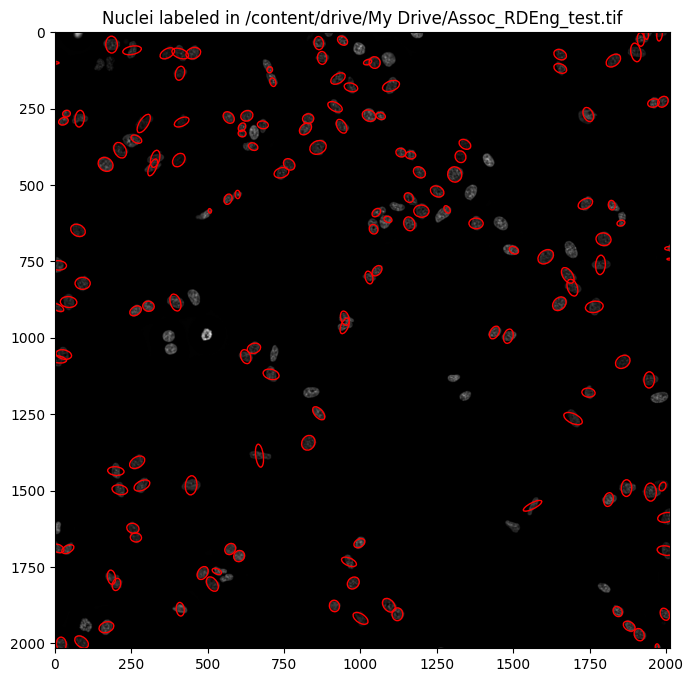

In [19]:
from matplotlib.patches import Ellipse

for path in file_paths:
    # Read the image as a grayscale 2D array using OpenCV
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Perform the segmentation using Cellpose
    masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0,0])

    # Create a figure and axis to plot the image
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image, cmap='gray')  # Display the image

    # Overlay ellipses on the original image for each region (nucleus)
    for region in regionprops(masks):
        if region.label == 0:  # Skip the background
            continue

        # For each region (nucleus), get the center, length of semi-major and semi-minor axes, and the orientation
        y0, x0 = region.centroid
        a = region.major_axis_length / 2
        b = region.minor_axis_length / 2
        orientation = region.orientation

        # Add an ellipse to the plot
        ellipse = Ellipse((x0, y0), 2*a, 2*b, angle=np.degrees(orientation), edgecolor='red', facecolor='none')
        ax.add_patch(ellipse)

    # Set the axis limits and show the plot
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)  # Images have the origin at the top-left corner, so invert the y-axis
    plt.title(f'Nuclei labeled in {path}')
    plt.show()

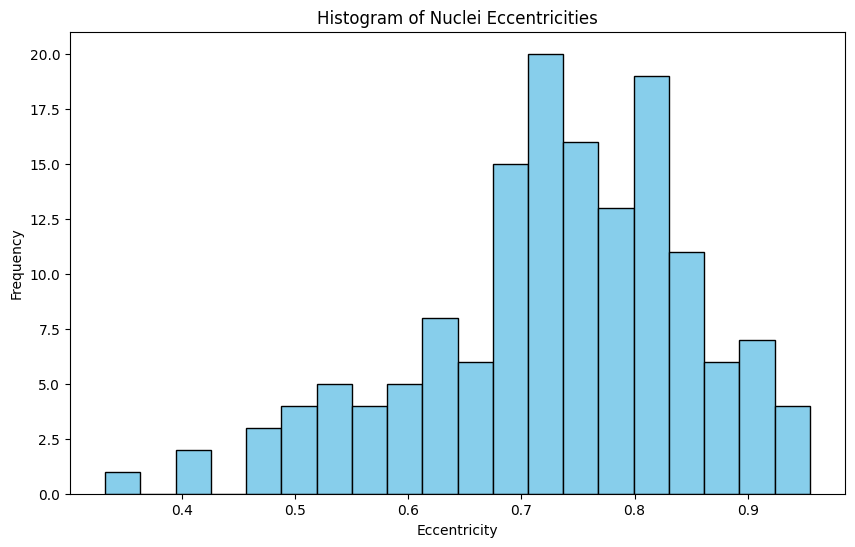

In [17]:
# Plotting the histogram of eccentricities
plt.figure(figsize=(10, 6))
plt.hist(all_eccentricities, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Nuclei Eccentricities')
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')
plt.show()